### Visualisation and time-series analysis

<span style="font-size: 12pt;">This notebook shows the visualisation and time-series analysis of the processed dataset stored on Hadoop.</span>

<br>

In [1]:
sc # check pyspark status

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
sc.master # check master

'local[*]'

In [3]:
# Import data from Hadoop using Spark
file_path = "/sentiment/climate_change_sentiment.csv"

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Time-series analysis").getOrCreate()

climate_change = spark.read.format("csv").option("header", "true").option("multiline", "true").load(file_path)
climate_change.show(3)

+----------+--------------------+---------+
|      date|               texts|sentiment|
+----------+--------------------+---------+
|2021-09-01|absolutely blunt ...|   0.9894|
|2021-09-01|canada essentiall...|  -0.1531|
|2021-09-01| come climate change|        0|
+----------+--------------------+---------+
only showing top 3 rows



In [4]:
# Check missing value
from pyspark.sql.functions import col, count, when

# Count the number of missing values in each column
missing_values = climate_change.select([count(when(col(c).isNull(), c)).alias(c) for c in climate_change.columns])

# Display the missing value counts
missing_values.show()

+----+-----+---------+
|date|texts|sentiment|
+----+-----+---------+
|   0|    0|        0|
+----+-----+---------+



In [5]:
# Add new column "category" based on sentiments
from pyspark.sql.types import DoubleType

climate_change = climate_change.withColumn("sentiment", climate_change["sentiment"].cast(DoubleType()))
climate_change = climate_change.withColumn(
    "category", when(climate_change.sentiment > 0, "positive").when(climate_change.sentiment < 0, "negative").otherwise("neutral"))

climate_change.show(5)

+----------+--------------------+---------+--------+
|      date|               texts|sentiment|category|
+----------+--------------------+---------+--------+
|2021-09-01|absolutely blunt ...|   0.9894|positive|
|2021-09-01|canada essentiall...|  -0.1531|negative|
|2021-09-01| come climate change|      0.0| neutral|
|2021-09-01|communism mean wo...|    0.872|positive|
|2021-09-01|data always lined...|   0.4939|positive|
+----------+--------------------+---------+--------+
only showing top 5 rows



<br>

### change to pandas dataframe

In [6]:
# Import mandatory libraries
import pandas as pd

In [7]:
# Change to pandas dataframe
climate_change_sentiment = climate_change.toPandas()
climate_change_sentiment.head()

,date,texts,sentiment,category
0,2021-09-01,absolutely blunt care person want power canada...,0.9894,positive
1,2021-09-01,canada essentially upgraded version united sta...,-0.1531,negative
2,2021-09-01,come climate change,0.0000,neutral
3,2021-09-01,communism mean worker compensated worker contr...,0.8720,positive
4,2021-09-01,data always lined predicted faster expected pl...,0.4939,positive


In [8]:
climate_change_sentiment.shape

(7300, 4)

In [9]:
climate_change_sentiment.duplicated().sum()

6

In [10]:
# Check what is duplicating
duplicate_bool = climate_change_sentiment.duplicated(
    subset = ["date", "texts", "sentiment", "category"], 
    keep = "first")
duplicate = climate_change_sentiment.loc[duplicate_bool == True]
duplicate

,date,texts,sentiment,category
642,2021-10-03,climate change,0.0000,neutral
2126,2021-12-16,climate change,0.0000,neutral
2325,2021-12-26,climate change,0.0000,neutral
3952,2022-03-17,nft proarguments argument written mrmoustachem...,0.9986,positive
4925,2022-05-05,climate change,0.0000,neutral
6464,2022-07-21,climate change isnt real,0.0000,neutral


<br>

<span style="font-size: 12pt;">*The potential reason of the duplicated items showing above is that the comments people posted are the same, for example "climate change". However, these are still opnions from different person. In order to avoid bias, these duplicates were not dropped.*</span>

<br>

In [11]:
climate_change_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       7300 non-null   object 
 1   texts      7300 non-null   object 
 2   sentiment  7300 non-null   float64
 3   category   7300 non-null   object 
dtypes: float64(1), object(3)
memory usage: 228.2+ KB


In [12]:
# Convert "date" type
climate_change_sentiment["date"] = pd.to_datetime(climate_change_sentiment["date"])
climate_change_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       7300 non-null   datetime64[ns]
 1   texts      7300 non-null   object        
 2   sentiment  7300 non-null   float64       
 3   category   7300 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 228.2+ KB


- <span style="font-size: 13pt;">***visualisation***</span>

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

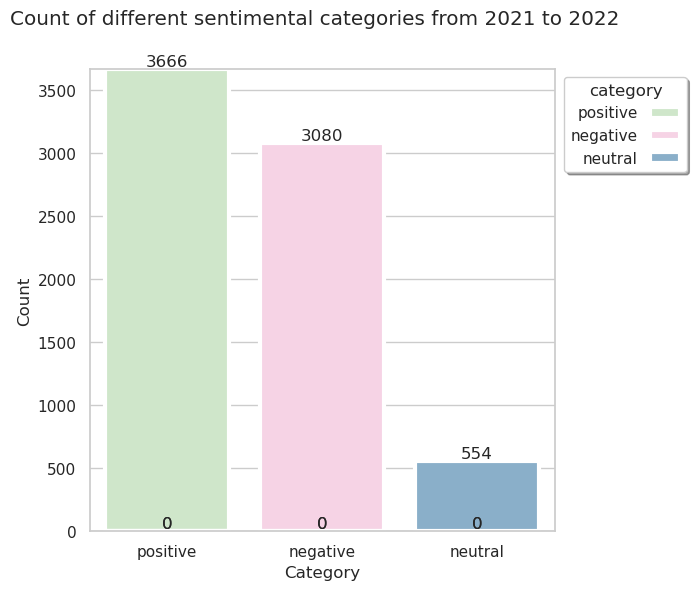

In [20]:
# Visualise the value counts in "category"
category_counts = climate_change_sentiment["category"].value_counts()

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Count of different sentimental categories from 2021 to 2022")

sns.set_theme(style="whitegrid")

ranks = climate_change_sentiment["category"].sort_values().index

palette = sns.color_palette("Set3", len(ranks))

sns.countplot(ax=axes, data=climate_change_sentiment, x="category",
              linewidth=3, hue="category",
              palette = np.array(palette)[ranks], dodge = False)

axes.set_xlabel("Category")
axes.set_ylabel("Count")

plt.legend(title="category", bbox_to_anchor=(1.3, 1),
           frameon=True, ncol=1,
           markerfirst=False, shadow=True)

for container in axes.containers:
    axes.bar_label(container)

axes.set_ylim(0, max(category_counts))

plt.show()

In [15]:
# Create a new dataframe {sentiment} only contains "date" and "sentiment"
sentiment = climate_change_sentiment[["date", "sentiment"]].copy()
sentiment.tail(6)

,date,sentiment
7294,2022-08-31,-0.3408
7295,2022-08-31,0.9879
7296,2022-08-31,0.8360
7297,2022-08-31,0.6597
7298,2022-08-31,0.4031
7299,2022-08-31,0.7430


In [16]:
# Aggregate the average of the sentiments based on "date"
sentiment_final = sentiment.groupby("date")["sentiment"].mean().reset_index()
sentiment_final.columns = ["date", "average sentiment"]
sentiment_final.head()

,date,average sentiment
0,2021-09-01,0.066240
1,2021-09-02,0.056645
2,2021-09-03,0.006905
3,2021-09-04,0.062800
4,2021-09-05,-0.087550


In [17]:
# Add "category" and assign to a new dataframe
sentiment_final_category = sentiment_final.copy()
sentiment_final_category["category"] = pd.cut(sentiment_final_category["average sentiment"], 
                                              bins=[-float("inf"), 0, float("inf")], 
                                              labels=["negative", "positive"])

sentiment_final_category.head(8)

,date,average sentiment,category
0,2021-09-01,0.066240,positive
1,2021-09-02,0.056645,positive
2,2021-09-03,0.006905,positive
3,2021-09-04,0.062800,positive
4,2021-09-05,-0.087550,negative
5,2021-09-06,-0.000375,negative
6,2021-09-07,-0.201935,negative
7,2021-09-08,0.074290,positive


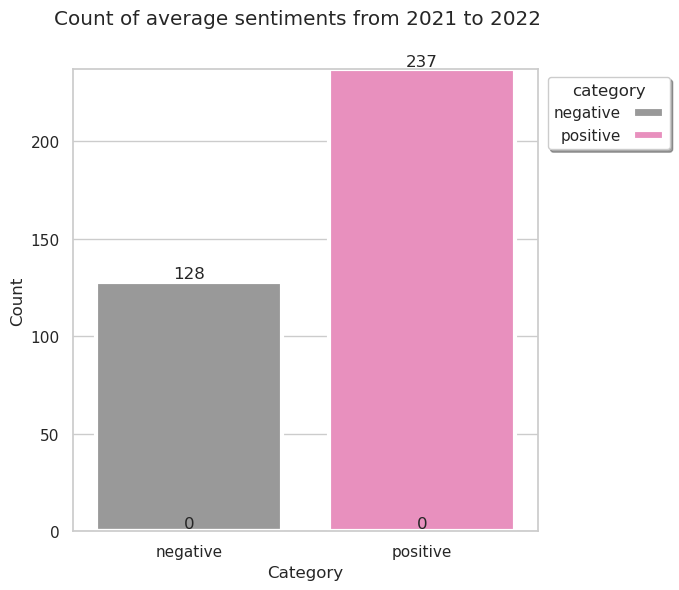

In [18]:
# Visualise the value counts of average sentiments
category_counts2 = sentiment_final_category["category"].value_counts()

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Count of average sentiments from 2021 to 2022")

sns.set_theme(style="whitegrid")

ranks = sentiment_final_category["category"].sort_values().index

palette = sns.color_palette("Set1", len(ranks))

sns.countplot(ax=axes, data=sentiment_final_category, x="category",
              linewidth=3, hue="category",
              palette = np.array(palette)[ranks], dodge = False)

axes.set_xlabel("Category")
axes.set_ylabel("Count")

plt.legend(title="category", bbox_to_anchor=(1.3, 1),
           frameon=True, ncol=1,
           markerfirst=False, shadow=True)

for container in axes.containers:
    axes.bar_label(container)

axes.set_ylim(0, max(category_counts2))

plt.show()

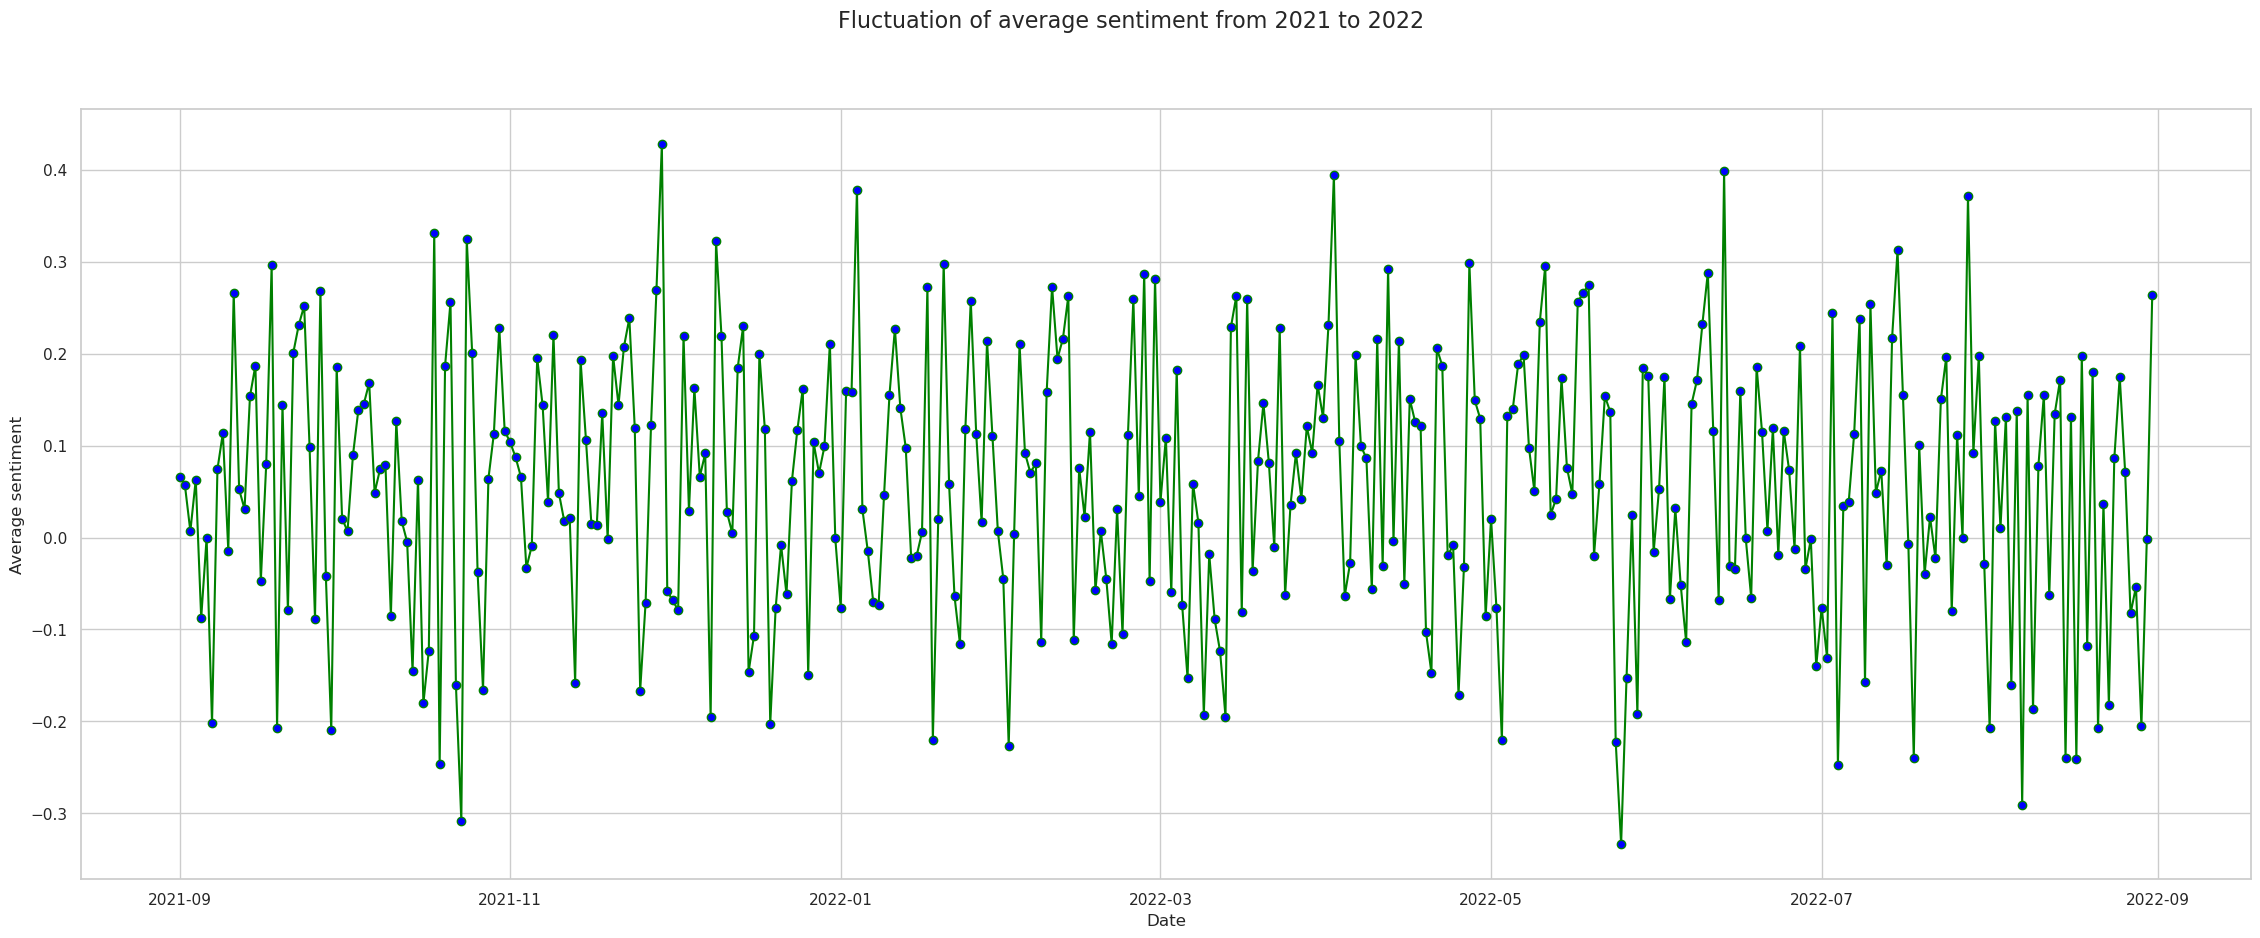

In [19]:
# Visualise the average sentiment change over time
fig, axes = plt.subplots(figsize=(28, 10))
fig.suptitle("Fluctuation of average sentiment from 2021 to 2022", fontsize=16)

axes.plot(sentiment_final["date"], sentiment_final["average sentiment"], 
          marker="o", linestyle="-",
          color="green", markerfacecolor="blue")

axes.set_xlabel("Date")
axes.set_ylabel("Average sentiment")

axes.grid(True)

plt.show()

<br>

<span style="font-size: 12pt;">The average sentiment from 2021-09-01 to 2022-08-31 reaches its highest around the end of November 2021, however, its lowest near the beginning of June 2022.</span>

- <span style="font-size: 13pt;">***time-series analysis***</span>